# GATK Hard Filtering Tutorial (Python)<a class="tocSkip">

**February 2020**  

<img src="https://storage.googleapis.com/gatk-tutorials/images/2-germline/vd-image1.png" alt="drawing" width="40%" align="left" style="margin:0px 20px"/> <font size ="4">This tutorial focuses on analyses post variant discovery. We will illustrate hard-filtering germline raw variant calls based on plots of site-level annotations. Our goals are to get you on the road to understanding variant annotations to enable you to evaluate callsets.

This notebook and the next one will show you methods for hard filtering, but we will also discuss how those apply in Variant Quality Score Recalibration (VQSR) which you have already expored. For generic hard-filtering recommendations, see [this article](https://gatk.broadinstitute.org/hc/en-us/articles/360035531112).</font>

_This tutorial was last tested with GATK v4.1.4.1 and IGV v2.8.0._
 See [GATK Tool Documentation](https://gatk.broadinstitute.org/hc/en-us/articles/360037224712) for further information on the tools we use below.

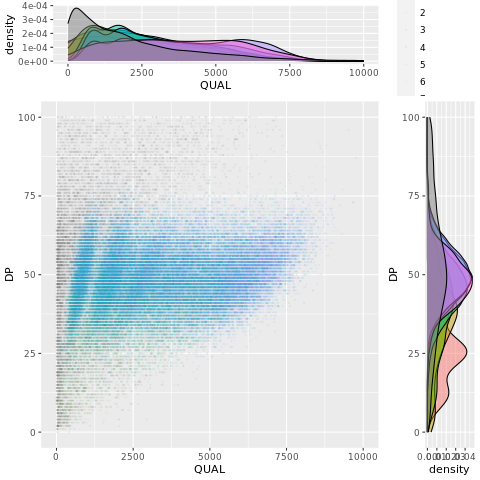

# Set up your Notebook

## Set cloud environment values
If you opened this notebook and didn't adjust any cloud environment values, now's the time to edit them. Click on the gear icon in the upper right to edit your Cloud Environment form. Set the values as specified below:

| Option | Value |
| ------ | ------ |
| Environment | Default |
| Profile | Custom |
| CPU | 4 |
| Disk size | 100 GB |
| Memory | 15 GB |

Click the "Update" button when you are done, and Terra will begin to create a new cloud environment with your settings. When it is finished, it will pop up asking you to apply the new settings. In the meantime, you can continue with the setup instructions below. 

## Set up rpy
This notebook uses Python for a majority, but we will do some graphing in R. In order to do so, we need to run the two commands below.

<font color = "green"> **Tool Tip:** To run a cell in a notebook, press `SHIFT + ENTER`</font>

In [ ]:
!pip install rpy2

Restart kernel before running the next cell

In [ ]:
import rpy2

In [ ]:
%load_ext rpy2.ipython

## Check kernel type
A kernel is a _computational engine_ that executes the code in the notebook. For this particular notebook, we will be using a Python 3 kernel so we can execute GATK commands using _Python Magic_ (`!`). In the upper right corner of the notebook, just under the Notebook Runtime, it should say `Python3`. If this notebook isn't running a Python 3 kernel, you can switch it by navigating to the Kernel menu and selecting `Change kernel`.

## Set up your files
Your notebook has a temporary folder that exists so long as your cluster is running. To see what files are in your notebook environment at any time, you can click on the Jupyter logo in the upper left corner. 

For this tutorial, we need to copy some files from this temporary folder to and from our workspace bucket. Run the two commands below to set up the workspace bucket variable and the file paths inside your notebook.

In [ ]:
# Set your workspace bucket variable for this notebook.
import os
BUCKET = os.environ['WORKSPACE_BUCKET']

In [ ]:
# Set workshop variable to access the most recent materials
WORKSHOP = "workshop_2002"

In [ ]:
# Create directories for your files to live inside this notebook
! mkdir -p /home/jupyter/notebooks/2-germline-vd/sandbox/
! mkdir -p /home/jupyter/notebooks/2-germline-vd/ref
! mkdir -p /home/jupyter/notebooks/2-germline-vd/resources
! mkdir -p /home/jupyter/notebooks/2-germline-vd/gvcfs
! mkdir -p /home/jupyter/notebooks/CNN/Output/

## Check data permissions
For this tutorial, we have hosted the starting files in a public Google bucket. We will first check that the data is available to your user account, and if it is not, we simply need to install Google Cloud Storage.

In [ ]:
# Check if data is accessible. The command should list several gs:// URLs.
! gsutil ls gs://gatk-tutorials/$WORKSHOP/2-germline/

In [ ]:
# If you do not see gs:// URLs listed above, run this cell to install Google Cloud Storage. 
# Afterwards, restart the kernel with Kernel > Restart.
#! pip install google-cloud-storage

## Download Data to the Notebook 
Some tools are not able to read directly from a Google bucket, so we download their files to our local notebook folder.

In [ ]:
! gsutil cp gs://gatk-tutorials/$WORKSHOP/2-germline/ref/* /home/jupyter/notebooks/2-germline-vd/ref
! gsutil cp gs://gatk-tutorials/$WORKSHOP/2-germline/trio.ped /home/jupyter/notebooks/2-germline-vd/
! gsutil cp gs://gatk-tutorials/$WORKSHOP/2-germline/resources/* /home/jupyter/notebooks/2-germline-vd/resources/

---
# Subset variants to SNPs of a single sample with SelectVariants

Subset the trio callset to just the SNPs of the mother (sample NA12878). Make sure to remove sites for which the sample genotype is homozygous-reference and remove unused alleles, including spanning deletions. 

> The tool recalculates depth of coverage (DP) per site as well as the allele count in genotypes for each ALT allele (AC), allele frequency for each ALT allele (AF), and  total number of alleles in called genotypes (AN), to reflect only the subset sample(s).

In [ ]:
! gatk SelectVariants \
-V gs://gatk-tutorials/$WORKSHOP/2-germline/illumina_platinum/trio.vcf.gz \
-sn NA12878 \
-select-type SNP \
--exclude-non-variants \
--remove-unused-alternates \
-O /home/jupyter/notebooks/motherSNP.vcf.gz

In [ ]:
# Peruse the resulting file 
! zcat /home/jupyter/notebooks/motherSNP.vcf.gz | grep -v '##' | head

---
## Annotate intersecting true positives with VariantAnnotator

We use VariantAnnotator to annotate which variants in our callset are also present in the truthset (GIAB), which are considered true positives. Variants not present in the truthset are considered false positives. Here we produce a callset where variants that are present in the truthset are annotated with the giab.callsets annotation plus a value indicating how many of the callsets used to develop the truthset agreed with that call.

In [ ]:
! gatk VariantAnnotator \
-V /home/jupyter/notebooks/motherSNP.vcf.gz \
--resource:giab gs://gatk-tutorials/$WORKSHOP/2-germline/resources/motherGIABsnps.vcf.gz \
-E giab.callsets \
-O /home/jupyter/notebooks/motherSNP.giab.vcf.gz

In [ ]:
# Peruse the resulting file 
! zcat /home/jupyter/notebooks/motherSNP.giab.vcf.gz | grep -v '##' | head

---
## Tabulate annotations of interest with VariantsToTable

Convert the information from the callset into a tab delimited table using VariantsToTable, so that we can parse it easily in R. The tool parameters differentiate INFO/site-level fields fields (`-F`) and FORMAT/sample-level fields genotype fields (`-GF`). This step produces a table where each line represents a variant record from the VCF, and each column represents an annotation we have specified. Wherever the requested annotations are not present, e.g. RankSum annotations at homozygous sites, the value will be replaced by NA. 

In [ ]:
! gatk VariantsToTable \
-V /home/jupyter/notebooks/motherSNP.giab.vcf.gz \
-F CHROM -F POS -F QUAL \
-F BaseQRankSum -F MQRankSum -F ReadPosRankSum \
-F DP -F FS -F MQ -F QD -F SOR \
-F giab.callsets \
-GF GQ \
-O /home/jupyter/notebooks/motherSNP.giab.txt

In [ ]:
# Peruse the resulting file
! cat /home/jupyter/notebooks/motherSNP.giab.txt | head -n300


---
## Make density and scatter plots in R and determine filtering thresholds

The rpy2 package loaded earlier allows a python notebook to run R scripts for intuitive exploration of the plots for this next section.

In [ ]:
%%R

# plotting.R script loads ggplot and gridExtra libraries and defines functions to plot variant annotations 
library(ggplot2)
install.packages("gridExtra")
library(gridExtra)

require(ggplot2, quietly = TRUE)
require(gridExtra, quietly = TRUE)

get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}


# Function for making density plots of a single annotation
makeDensityPlot <- function(dataframe, xvar, split, xmin=min(dataframe[xvar], na.rm=TRUE), xmax=max(dataframe[xvar], na.rm=TRUE), alpha=0.5) {
  
  if(missing(split)) {
    return(ggplot(data=dataframe, aes_string(x=xvar)) + xlim(xmin,xmax) + geom_density() )
  }
  else {
    return(ggplot(data=dataframe, aes_string(x=xvar, fill=split)) + xlim(xmin,xmax) + geom_density(alpha=alpha) )
  }
}

# Function for making scatter plots of two annotations
makeScatterPlot <- function(dataframe, xvar, yvar, split, xmin=min(dataframe[xvar], na.rm=TRUE), xmax=max(dataframe[xvar], na.rm=TRUE), ymin=min(dataframe[yvar], na.rm=TRUE), ymax=max(dataframe[yvar], na.rm=TRUE), ptSize=1, alpha=0.6) {
  if(missing(split)) {
    return(ggplot(data=dataframe) + aes_string(x=xvar, y=yvar) + xlim(xmin,xmax) + ylim(ymin,ymax) + geom_point(size=ptSize, alpha=alpha) )
  }
  else {
    return(ggplot(data=dataframe) + aes_string(x=xvar, y=yvar) + aes_string(color=split) + xlim(xmin,xmax) + ylim(ymin,ymax) + geom_point(size=ptSize, alpha=alpha) )
  }
}

# Function for making scatter plots of two annotations with marginal density plots of each
makeScatterPlotWithMarginalDensity <- function(dataframe, xvar, yvar, split, xmin=min(dataframe[xvar], na.rm=TRUE), xmax=max(dataframe[xvar], na.rm=TRUE), ymin=min(dataframe[yvar], na.rm=TRUE), ymax=max(dataframe[yvar], na.rm=TRUE), ptSize=1, ptAlpha=0.6, fillAlpha=0.5) {
  empty <- ggplot()+geom_point(aes(1,1), colour="white") +
    theme(
      plot.background = element_blank(), 
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.border = element_blank(), 
      panel.background = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks = element_blank()
    )
  
  if(missing(split)){
    scatter <- ggplot(data=dataframe) + aes_string(x=xvar, y=yvar) + geom_point(size=ptSize, alpha=ptAlpha) + xlim(xmin,xmax) + ylim(ymin,ymax) 
    plot_top <- ggplot(data=dataframe, aes_string(x=xvar)) + geom_density(alpha=fillAlpha) + theme(legend.position="none") + xlim(xmin,xmax) 
    plot_right <- ggplot(data=dataframe, aes_string(x=yvar)) + geom_density(alpha=fillAlpha) + coord_flip() + theme(legend.position="none") + xlim(ymin,ymax) 
  } 
  else{
    scatter <- ggplot(data=dataframe) + aes_string(x=xvar, y=yvar) + geom_point(size=ptSize, alpha=ptAlpha, aes_string(color=split)) + xlim(xmin,xmax) + ylim(ymin,ymax) 
    plot_top <- ggplot(data=dataframe, aes_string(x=xvar, fill=split)) + geom_density(alpha=fillAlpha) + theme(legend.position="none") + xlim(xmin,xmax) 
    plot_right <- ggplot(data=dataframe, aes_string(x=yvar, fill=split)) + geom_density(alpha=fillAlpha) + coord_flip() + theme(legend.position="none") + xlim(ymin,ymax) 
  }
  legend <- get_legend(scatter)
  scatter <- scatter + theme(legend.position="none")
  temp <- grid.arrange(plot_top, legend, scatter, plot_right, ncol=2, nrow=2, widths=c(4,1), heights=c(1,4))
  return(temp)
}

---
# Make density and scatter plots in R and determine filtering thresholds

Now you're ready to start! Plotting the density of values for an annotation shows us to see the overall range and distribution of values observed in a callset. In combination with some basic knowledge of what the annotation represents and how it is calculated, this allows us to make a first estimation of value thresholds that segregate FPs from TPs. Plotting the scatter of values for two annotations, one against the other, additionally shows us what tradeoffs we make when setting a threshold on annotation values individually. 

## Make a density plot for QUAL with the `makeDensityPlot` function

Iteratively improve the plot by modifying `qual`. Here are some suggestions to start.
- B = makeDensityPlot(motherSNP.giab, "QUAL")
- B = makeDensityPlot(motherSNP.giab, "QUAL", xmax=10000)
- B = makeDensityPlot(motherSNP.giab, "QUAL", xmax=10000, split="giab.callsets")

> _How does the density distribution relate to what the annotation represents? Can we find some clues of what might distinguish good vs. bad variants?_
> _When we plot the split version, can we see a clear difference between the set distributions? What does that tell us?_

In [ ]:
%%R
# Call the readr library and use its read_delim function to load motherSNP.giab.txt into the 
# motherSNP.giab object.
library(readr)
motherSNP.giab <- read_delim("/home/jupyter/notebooks/motherSNP.giab.txt","\t", 
              escape_double = FALSE, col_types = cols(giab.callsets = col_character()), trim_ws = TRUE)

Below are three different plotting functions. Uncomment them one at a time and see how the graph changes as you alter them. To uncomment, simply remove the `#` at the beginning of the line, and put it in front of the line you no longer want to graph.

In [ ]:
%%R
#B = makeDensityPlot(motherSNP.giab, "QUAL")
#B = makeDensityPlot(motherSNP.giab, "QUAL", xmax=10000)
B = makeDensityPlot(motherSNP.giab, "QUAL", xmax=10000, split="giab.callsets")

In [ ]:
%%R
B

## Make a QD (QualByDepth) density plot

QD puts the variant confidence QUAL score into perspective by normalizing for the amount of coverage available. Because each read contributes a little to the QUAL score, variants in regions with deep coverage can have artificially inflated QUAL scores, giving the impression that the call is supported by more evidence than it really is. To compensate for this, we normalize the variant confidence by depth, which gives us a more objective picture of how well supported the call is.

> _What do the peaks represent?_

In [ ]:
%%R
# Change up the parameters, e.g. add 'split="giab.callsets"', examine RankSums (eg MQRankSum), FS and SOR
#C = makeDensityPlot(motherSNP.giab, "QD")
C = makeDensityPlot(motherSNP.giab, "QD", split="giab.callsets")

In [ ]:
%%R
# Plot 'C'
C

## Make a scatterplot winged by marginal density plots

The `makeScatterPlotWithMarginalDensity` function defines and plots. The `ptAlpha` parameter changes the transparency of the points. 

> _When plotting two annotations, does the combination of the two tell us anything more than either did separately?_

- Try adjusting the parameters.
- Substitute in other annotations. For example, the following recreates the plot on the front page of the tutorial worksheet.

```
F = makeScatterPlotWithMarginalDensity(motherSNP.giab, "QUAL", "DP", split="set", xmax=10000, ymax=100, ptSize=0.5, ptAlpha=0.05)
```




---

For reference, here are some basic filtering thresholds to improve upon.

- -filter "QD < 2.0"
- -filter "QUAL < 30.0"
- -filter "SOR > 3.0"
- -filter "FS > 60.0"
- -filter "MQ < 40.0"
- -filter "MQRankSum < -12.5 
- -filter "ReadPosRankSum < -8.0"

---

In [ ]:
%%R

E = makeScatterPlotWithMarginalDensity(motherSNP.giab, 
                                       "QD", "DP", 
                                       split="giab.callsets", 
                                       ymax=250, 
                                       ptSize=0.5, ptAlpha=0.2)

In [ ]:
# Blank cell for free use. Add additional cells with Menu > Insert.
# Change the cell type with Cell > Cell Type.
# Delete a cell with Edit > Delete Cells.

---
## Apply filters with VariantFiltration and evaluate results

### Filter on QUAL and tabulate baseline concordance

Based on the plots we generated, we're going to apply some filters to weed out false positives. To illustrate how VariantFiltration works, and to establish baseline performance, we first filter on QUAL < 30. By default, GATK GenotypeGVCFs filters out variants with QUAL < 10. This step produces a VCF with all the original variants; those that failed the filter are annotated with the filter name in the FILTER column.


In [ ]:
# Filter callset on one annotation, QUAL < 30
! gatk VariantFiltration \
-R gs://gatk-tutorials/$WORKSHOP/2-germline/ref/ref.fasta \
-V /home/jupyter/notebooks/motherSNP.vcf.gz \
--filter-expression "QUAL < 30" \
--filter-name "qual30" \
-O /home/jupyter/notebooks/motherSNPqualqd.vcf.gz

In [ ]:
# Peruse the results; try adding 'grep "qual30"'
! zcat /home/jupyter/notebooks/motherSNPqualqd.vcf.gz | grep -v '##' | head -n100

### Filter on multiple annotations simultaneously using VariantFiltration

To filter on multiple expressions, provide each in separate expression. For INFO level annotations, the parameter is  `-filter`, which should be immediately followed by the corresponding `–-filter-name` label. Here we show basic hard-filtering thresholds.

- If an annotation is missing, VariantFiltration skips any judgement on that annotation. To conservatively fail such missing annotation sites, set the `--missing-values-evaluate-as-failing` flag. 
- To filter based on FORMAT level annotations, use `--genotype-filter-expression` and `--genotype-filter-name`. 

In [ ]:
# Filter callset on multiple annotations.
# Iterate on thresholds to improve precision while maintaining high sensitivity.
! gatk VariantFiltration \
-V /home/jupyter/notebooks/motherSNP.vcf.gz \
-filter "QD < 2.0" --filter-name "QD2" \
-filter "QUAL < 30.0" --filter-name "QUAL30" \
-filter "SOR > 3.0" --filter-name "SOR3" \
-filter "FS > 60.0" --filter-name "FS60" \
-filter "MQ < 40.0" --filter-name "MQ40" \
-filter "MQRankSum < -12.5" --filter-name "MQRankSum-12.5" \
-filter "ReadPosRankSum < -8.0" --filter-name "ReadPosRankSum-8" \
-O /home/jupyter/notebooks/motherSNPfilters.vcf.gz

In [ ]:
# Confidence check that filtering is as expected by examining filtered records and PASS records.
! zcat /home/jupyter/notebooks/motherSNPfilters.vcf.gz | grep -v '##' | grep -v 'PASS' | head -n20 | cut -f6-10

### Calculate Concordance

In [ ]:
! gatk Concordance \
-eval /home/jupyter/notebooks/motherSNPfilters.vcf.gz \
-truth gs://gatk-tutorials/$WORKSHOP/2-germline/resources/motherGIABsnps.vcf.gz \
-L gs://gatk-tutorials/$WORKSHOP/2-germline/intervals/motherHighconf.bed \
-S /home/jupyter/notebooks/motherSNPfilters.txt

In [ ]:
! cat /home/jupyter/notebooks/motherSNPfilters.txt

In [ ]:
#Now lets re-run concordance from just using QUAL filtering first
! gatk Concordance \
-eval /home/jupyter/notebooks/motherSNPqualqd.vcf.gz \
-truth gs://gatk-tutorials/$WORKSHOP/2-germline/resources/motherGIABsnps.vcf.gz \
-L gs://gatk-tutorials/$WORKSHOP/2-germline/intervals/motherHighconf.bed \
-S /home/jupyter/notebooks/motherSNPqualqd.txt

In [ ]:
# View the results
! cat /home/jupyter/notebooks/motherSNPqualqd.txt

---

We performed hard-filtering to learn about germline variant annotations. Remember that GATK recommends VETS or the CNN for germline variant callset filtering. For more complex variant filtering and annotation, see the Broad [Hail.is](https://hail.is/index.html) framework. 